In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [60]:
Ts = 0.38
Vitesse = 200

W = 40*np.identity(2)
V_c = 40

In [61]:
A = np.array([[1, Ts],
              [0, 1]])

C = np.array([[0, 1]])

def g_nc(z):
    return C@z

def grad_g_nc(z):
    return C

def constructing_s(V_left_measured, V_right_measured):
    return (V_left_measured+V_right_measured)/2

def filtering_step(z_k_k_1, sigma_k_k_1, V_left_measured, V_right_measured):
    ### Computing the variables that are dependant on the state of the camera
    C_k = grad_g_nc(z_k_k_1)
    s_k = constructing_s(V_left_measured=V_left_measured,
                         V_right_measured=V_right_measured)
    g_k = g_nc(z_k_k_1)

    ### The real filtering step that can be rewritten without any problem
    L_k_k = sigma_k_k_1@C_k.T@np.linalg.inv(C_k@sigma_k_k_1@C_k.T + V_c)
    sigma_k_k = sigma_k_k_1 - L_k_k@C_k@sigma_k_k_1
    z_k_k = z_k_k_1 + L_k_k@(s_k-g_k)

    return z_k_k, sigma_k_k

def prediction_step(z_k_k, sigma_k_k):
    z_k_1_k = A@z_k_k
    sigma_k_1_k = A@sigma_k_k@A.T + W
    return z_k_1_k, sigma_k_1_k

In [62]:
z_0 = np.array([0,Vitesse])
sigma_0 = np.diag([0.1,0.1])

N = 100 # Durée expérience

z=np.zeros((2,N))
z[:,0] = z_0
for i in range(1,N):
    z[:,i] = np.array([Ts*i*Vitesse,Vitesse])

In [71]:
z_filtered = []
sigma_filtered = []

z_predicted = [z_0]
sigma_predicted = [sigma_0]

for i in range(N):
    Vitesse_left = Vitesse + np.random.normal(scale=V_c)
    Vitesse_right = Vitesse + np.random.normal(scale=V_c)
    z_k_k, sigma_k_k= filtering_step(z_k_k_1 = z_predicted[-1], 
                                    sigma_k_k_1 = sigma_predicted[-1], 
                                    V_left_measured=Vitesse_left,
                                    V_right_measured=Vitesse_right)
    
    z_filtered.append(z_k_k)
    sigma_filtered.append(sigma_k_k)

    z_k_1_k, sigma_k_1_k = prediction_step(z_k_k, sigma_k_k)
    z_predicted.append(z_k_1_k)
    sigma_predicted.append(sigma_k_1_k)

In [72]:
z_filtered_array = np.array(z_filtered)
z_filtered_array = z_filtered_array.T

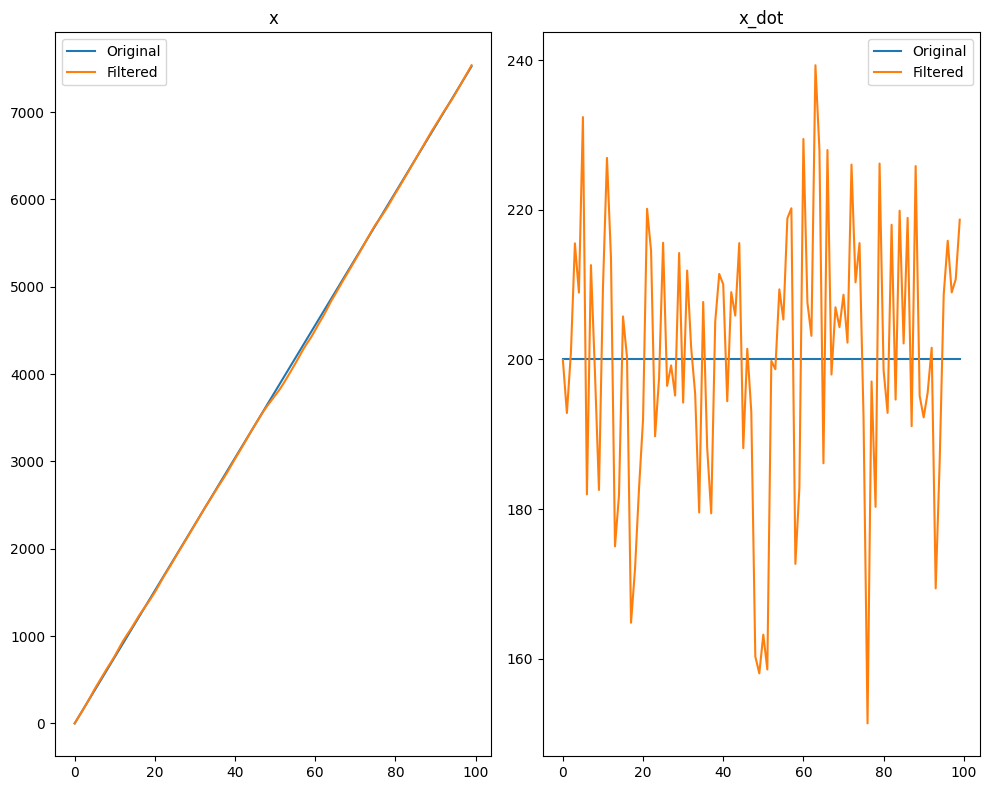

In [73]:
# Define the titles for each subplot
titles = ["x", "x_dot"]

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each row of z and z_filtered_array on its corresponding subplot
for i in range(2):
    axes[i].plot(z[i, :], label='Original')
    axes[i].plot(z_filtered_array[i, :], label='Filtered')
    axes[i].set_title(titles[i])
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Test en conditions réelles

In [58]:
import thymio_KS as th
import time
import numpy as np
import matplotlib.pyplot as plt

In [59]:
### Setting up the origin and the kalman filter
current_pos = np.array([0,0,0])
current_speed = np.array([0,0,0])
z_predicted = np.array([0,0]) #kalman_state
sigma_predicted = np.diag([0,0])

### Goal pos
goal_pos = np.array([300,0])


print("Open thymio")
thymio = th.Thymio()
await thymio.initiateLock()
print("Thymio opened")

Open thymio


CancelledError: 

In [ ]:
### Data storage for plotting
xdata, Vleftdata, Vrightdata = [], [], []
iteration_times = []
vars_towait = ['prox.horizontal','motor.right.speed','motor.left.speed','motor.right.target','motor.right.target']
    
while True:
    start_time = time.time()  # Capture start time
    thymio.wait_for_variables(vars_towait)

    if thymio.robot_close_waypoint(current_pos[:2], goal_pos[0], goal_pos[1]):
        print("Goal reached")
        thymio.set_multiple_variables({"motor.left.target":[0],"motor.right.target":[0]})
        break
    
    
    Vleft = thymio.getSpeedL()
    Vright = thymio.getSpeedR()

    thymio.navigate(current_pos, goal_pos)
    current_pos = np.concatenate([z_predicted,[0]]) # Is used for the controller

    xdata.append(current_pos[0])
    Vleftdata.append(Vleft)
    Vrightdata.append(Vright)

    z_filtered, sigma_filtered= thymio.filtering_step(z_k_k_1 = z_predicted, 
                                    sigma_k_k_1 = sigma_predicted, 
                                    V_left_measure = Vleft, 
                                    V_right_measure = Vright)
    
    z_predicted, sigma_predicted = thymio.prediction_step(z_filtered, sigma_filtered)

    obstacle,detected = thymio.getObstaclePosition()
    if detected:
        print("Obstacle detected")
        
    

    end_time = time.time()  # Capture end time
    iteration_time = end_time - start_time  # Compute iteration time
    iteration_times.append(iteration_time)  # Store iteration time
    print(f"Iteration time: {iteration_time:.6f} seconds")  # Print iteration time


Is the goal reached ?
False
{'motor.left.target': [225], 'motor.right.target': [225]}
Iteration time: 0.409990 seconds
Is the goal reached ?
False
{'motor.left.target': [225], 'motor.right.target': [225]}
Iteration time: 0.307490 seconds
Is the goal reached ?
False
{'motor.left.target': [225], 'motor.right.target': [225]}
Iteration time: 0.306039 seconds
Is the goal reached ?
False
{'motor.left.target': [225], 'motor.right.target': [225]}
Iteration time: 0.308402 seconds
Is the goal reached ?
False
{'motor.left.target': [225], 'motor.right.target': [225]}
Iteration time: 0.309077 seconds
Is the goal reached ?
False
{'motor.left.target': [0], 'motor.right.target': [0]}
Iteration time: 0.308681 seconds
Is the goal reached ?
False
{'motor.left.target': [0], 'motor.right.target': [0]}
Iteration time: 0.307927 seconds
Is the goal reached ?
False
{'motor.left.target': [0], 'motor.right.target': [0]}
Iteration time: 0.305544 seconds
Is the goal reached ?
False
{'motor.left.target': [0], 'moto

In [ ]:
Vitesse= 225

thymio.set_multiple_variables({"motor.left.target":[Vitesse],"motor.right.target":[Vitesse]})

{'motor.left.target': [300], 'motor.right.target': [300]}


In [ ]:
thymio.set_multiple_variables({"motor.left.target":[0],"motor.right.target":[0]})

{'motor.left.target': [0], 'motor.right.target': [0]}


In [ ]:
print(f'Première estimation Ts = {np.mean(np.array(iteration_times))}')

Première estimation Ts = 0.311940332253774


## Affichages

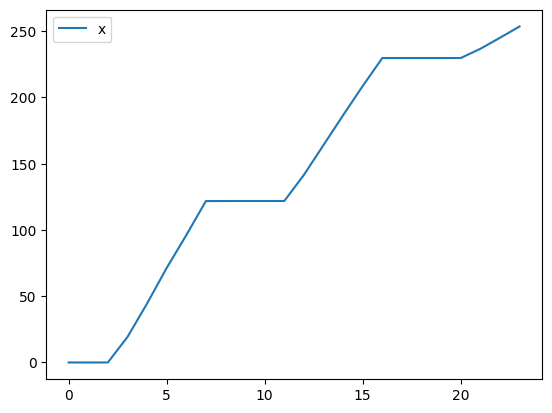

In [ ]:
plt.plot(xdata, label='x')
plt.legend()

In [ ]:
xdata

[0,
 0.0,
 0.0,
 19.223542008888888,
 44.48294452991453,
 71.33034498333333,
 96.03633347852684,
 121.80204618483548,
 121.84368435083788,
 121.84975929929033,
 121.85064562279092,
 121.85077493565686,
 141.556482438532,
 164.0698998569148,
 186.58343257285227,
 208.6478348061385,
 229.75779957884293,
 229.7578056290635,
 229.7578065117788,
 229.75780664056524,
 229.75780665935494,
 236.719603375607,
 245.02884465565324,
 253.562660031943]

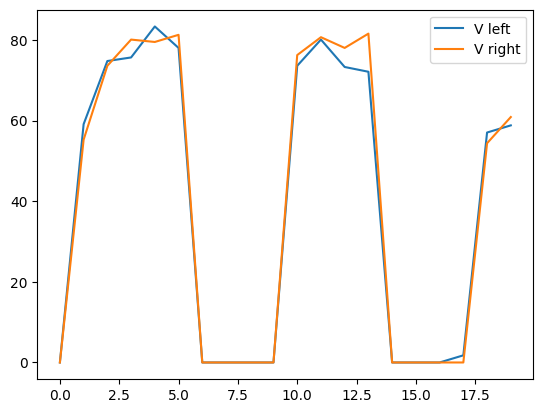

In [ ]:
Vleftdata = np.array(Vleftdata)
Vrightdata = np.array(Vrightdata)

plt.plot(Vleftdata, label="V left")
plt.plot(Vrightdata, label="V right")
plt.legend()

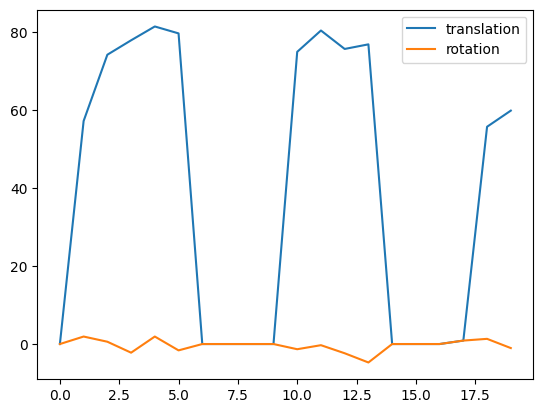

In [ ]:
plt.plot((Vleftdata+Vrightdata)/2, label = "translation")
plt.plot((Vleftdata-Vrightdata)/2, label = "rotation")
plt.legend()

[0, 0.0, 21.727543100000002, 49.91159125555556, 79.49922746666667, 110.4343082111111, 140.69566668888888, 140.69566668888888, 140.69566668888888, 140.69566668888888, 140.69566668888888, 169.16043245555554, 199.7025085444444, 228.4479919222222, 257.64262347777776, 257.64262347777776, 257.64262347777776, 257.64262347777776, 257.9794846111111, 279.1455924888889]


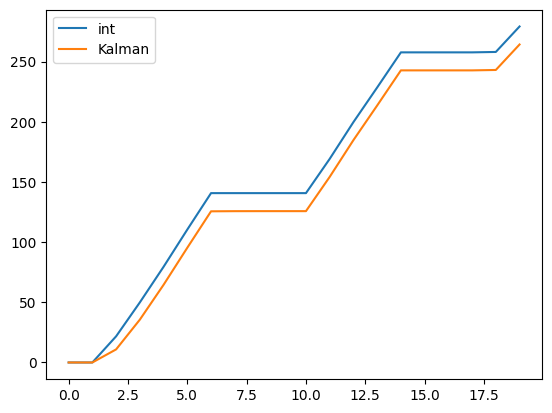

In [ ]:
V = (Vrightdata + Vleftdata)/2
Distance = [0]
Ts=0.38

for i in range(len(V)-1):
    Distance.append(Distance[-1] + Ts*V[i])

print(Distance)
plt.plot(Distance, label="int")
plt.plot(xdata, label="Kalman")
plt.legend()